In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as data_sets
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np

import sklearn.metrics as sk

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torchvision.datasets as data_sets
mnist_train_data=data_sets.MNIST('mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data=data_sets.MNIST('mnist', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Processing...
Done!


In [3]:
developement_size=18000
mnist_train_data, mnist_developement_set = random_split(mnist_train_data, [len(mnist_train_data) - developement_size, developement_size])

In [4]:
print('Train Dataset :', len(mnist_train_data), "\nValidation Dataset:" ,len(mnist_developement_set))

Train Dataset : 42000 
Validation Dataset: 18000


In [5]:
batch_size = 128

In [6]:
train_data_loader = DataLoader(dataset=mnist_train_data,batch_size= batch_size,num_workers=2,pin_memory=True,shuffle=True)
developement_data_loader = DataLoader(dataset = mnist_developement_set,batch_size = batch_size*2,num_workers=2,pin_memory=True)
test_data_loader = DataLoader(dataset=mnist_test_data,batch_size= batch_size,num_workers=2,pin_memory=True,shuffle=False)

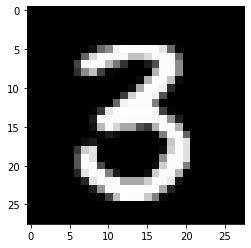

In [7]:
plt.imshow(mnist_train_data[0][0][0], cmap="gray")

Shape of Images: torch.Size([128, 1, 28, 28])


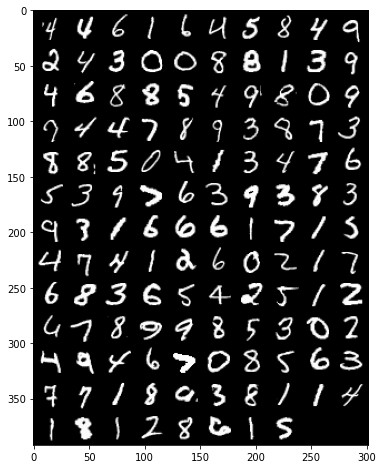

In [8]:
iterobj = iter(train_data_loader)
images, labels = iterobj.next()
print('Shape of Images:', images.shape)
plt.figure(figsize=(16,8))
plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))

while building the model, sending the dropout metric while initialising the instance of the class. dropout implemented after the two convolutional 2D layers

In [9]:
class CNN_with_Dropout(nn.Module):
    def __init__(self, dropout_value):
        super(CNN_with_Dropout, self).__init__()         
        self.l1 = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
        self.l2= nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout=nn.Dropout(dropout_value)
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        nn.init.xavier_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(1000, 10)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, batch_data):
        batch_data = self.l1(batch_data)
        batch_data = self.l2(batch_data)
        batch_data = batch_data.reshape(batch_data.size(0), -1)
        batch_data = self.dropout(batch_data)
        batch_data = self.fc1(batch_data)
        batch_data = self.fc2(batch_data)
        return batch_data
    
    def train_each_batch(self, images, labels):
        result = self(images)
        loss = Loss(result, labels)
        return loss

    def develope_each_batch(self, images, labels):
        # images =  batch[0]
        # labels = batch[1]
        result = self(images)                   
        loss = Loss(result, labels)
        acc = accuracy(result, labels)      
        return {'loss_at_end_of_batch': loss, 'acc_at_end_of_batch': acc}
      
    def develope_at_end_of_epoch(self, results):
        losses_at_end_of_batch = [x['loss_at_end_of_batch'] for x in results]
        loss_at_end_of_epoch = torch.stack(losses_at_end_of_batch).mean()  
        accs_at_each_batch = [x['acc_at_end_of_batch'] for x in results]
        acc_at_end_of_epoch = torch.stack(accs_at_each_batch).mean() 
        return {'loss_at_end_of_epoch': loss_at_end_of_epoch.item(), 'acc_at_end_of_epoch': acc_at_end_of_epoch.item()}

    def display_metrics_at_end_of_epoch(self, epoch, result):
        print("acc_at_end_of_epoch: {:.4f}, loss_at_end_of_epoch: {:.4f}".format(result['acc_at_end_of_epoch'], result['loss_at_end_of_epoch']))

In [10]:
def accuracy(results, labels):
    _, predictions = torch.max(results, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

In [11]:
def develope(network, developement_data_loader):
    results = [network.develope_each_batch(images, labels) for j, (images, labels) in enumerate(developement_data_loader)]
    return network.develope_at_end_of_epoch(results)

first drop out =0.25

In [12]:
network_first=CNN_with_Dropout(0.25)

In [13]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network_first.parameters(), lr = 0.001, momentum = 0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:
def train(epochs, model, train_data_loader, developement_data_loader, optimizer):    
    epoch_metrics = []
    for epoch in range(epochs): 
        lr = scheduler.step()
        print('Epoch:', epoch,'Learning rate:', scheduler.get_lr())
        for j,(images, labels) in enumerate(train_data_loader):
            loss = model.train_each_batch(images, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = develope(model, developement_data_loader)
        model.display_metrics_at_end_of_epoch(epoch, result)
        epoch_metrics.append(result)
        print("\n")
    return epoch_metrics

In [15]:
metrics_history_first = train(10, network_first, train_data_loader, developement_data_loader, optimizer)

Epoch: 0 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9525, loss_at_end_of_epoch: 0.1512


Epoch: 1 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9637, loss_at_end_of_epoch: 0.1125


Epoch: 2 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9699, loss_at_end_of_epoch: 0.0925


Epoch: 3 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9743, loss_at_end_of_epoch: 0.0833


Epoch: 4 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9788, loss_at_end_of_epoch: 0.0711


Epoch: 5 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9770, loss_at_end_of_epoch: 0.0727


Epoch: 6 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9814, loss_at_end_of_epoch: 0.0613


Epoch: 7 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9810, loss_at_end_of_epoch: 0.0608


Epoch: 8 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9806, loss_at_end_of_epoch: 0.0615


Epoch: 9 Learning rate: [1e-05]
acc_at_end_of_epoch: 0.9830, loss_at_end_of_epoch: 0.0576




In [16]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
else:
    device=torch.device("cpu")
print(device)

cpu


In [17]:
def test(network, test_data_loader):
  network.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    actuals = []
    predictions = []
    for images, labels in test_data_loader:
        images = Variable(images)
        results = network(images)
        prediction = results.argmax(dim=1, keepdim=True)
        actuals.extend(labels.view_as(prediction))
        predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

#     return (correct / total) * 100

In [20]:
print("After Test : ")
# print("Accuracy of the model :",acc_of_test)
actuals, predictions = test(network_first, test_data_loader)
print('Confusion matrix:')
print(sk.confusion_matrix(actuals, predictions))

After Test : 
Confusion matrix:
[[ 977    0    0    0    0    0    1    1    1    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   2    3 1024    0    1    0    0    1    1    0]
 [   1    0    1 1003    0    2    0    2    1    0]
 [   0    0    0    0  973    0    1    1    3    4]
 [   2    0    0    5    0  884    1    0    0    0]
 [   7    2    0    1    1    2  944    0    1    0]
 [   0    1    9    1    0    0    0 1013    1    3]
 [   3    1    2    1    1    1    1    3  958    3]
 [   3    3    1    1    4    5    0    4    1  987]]


In [21]:
print('Accuracy score: %f' % sk.accuracy_score(actuals, predictions))

Accuracy score: 0.989700


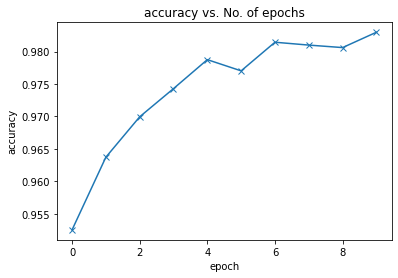

In [22]:
accs=[x['acc_at_end_of_epoch'] for x in metrics_history_first]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

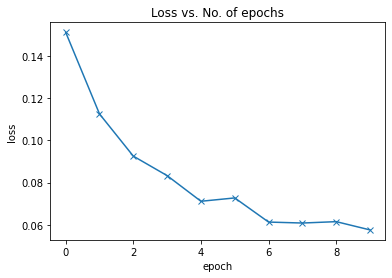

In [23]:
losses = [x['loss_at_end_of_epoch'] for x in metrics_history_first]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [24]:
# second dropout = 0.5

In [25]:
network_second=CNN_with_Dropout(0.5)

In [26]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network_second.parameters(), lr = 0.001, momentum = 0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [27]:
metrics_history_second = train(10, network_second, train_data_loader, developement_data_loader, optimizer)

Epoch: 0 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9451, loss_at_end_of_epoch: 0.1751


Epoch: 1 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9623, loss_at_end_of_epoch: 0.1202


Epoch: 2 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9653, loss_at_end_of_epoch: 0.1104


Epoch: 3 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9711, loss_at_end_of_epoch: 0.0943


Epoch: 4 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9736, loss_at_end_of_epoch: 0.0868


Epoch: 5 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9765, loss_at_end_of_epoch: 0.0792


Epoch: 6 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9759, loss_at_end_of_epoch: 0.0778


Epoch: 7 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9764, loss_at_end_of_epoch: 0.0781


Epoch: 8 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9782, loss_at_end_of_epoch: 0.0717


Epoch: 9 Learning rate: [1e-05]
acc_at_end_of_epoch: 0.9797, loss_at_end_of_epoch: 0.0663




In [28]:
print("After Test : ")
# print("Accuracy of the model :",acc_of_test)
actuals, predictions = test(network_second, test_data_loader)
print('Confusion matrix:')
print(sk.confusion_matrix(actuals, predictions))

After Test : 
Confusion matrix:
[[ 976    0    0    0    0    1    1    1    1    0]
 [   0 1132    1    1    0    1    0    0    0    0]
 [   2    1 1027    0    0    0    0    2    0    0]
 [   0    0    3  999    0    4    0    2    2    0]
 [   0    0    0    0  976    0    1    1    2    2]
 [   2    0    0    5    0  884    1    0    0    0]
 [   5    3    0    0    1    5  941    0    3    0]
 [   0    3    9    1    0    0    0 1011    1    3]
 [   4    0    2    1    1    1    0    2  959    4]
 [   4    3    1    1    6    4    0    5    2  983]]


In [29]:
print('Accuracy score: %f' % sk.accuracy_score(actuals, predictions))

Accuracy score: 0.988800


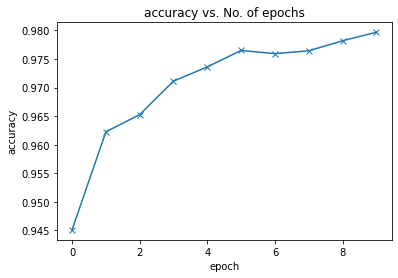

In [30]:
accs=[x['acc_at_end_of_epoch'] for x in metrics_history_second]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

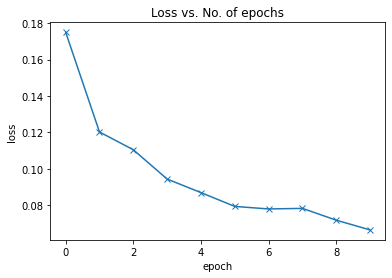

In [31]:
losses = [x['loss_at_end_of_epoch'] for x in metrics_history_second]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [32]:
# third dropout = 0.75

In [33]:
network_third=CNN_with_Dropout(0.75)

In [34]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network_third.parameters(), lr = 0.001, momentum = 0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [35]:
metrics_history_third = train(10, network_third, train_data_loader, developement_data_loader, optimizer)

Epoch: 0 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9113, loss_at_end_of_epoch: 0.2927


Epoch: 1 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9381, loss_at_end_of_epoch: 0.2034


Epoch: 2 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9474, loss_at_end_of_epoch: 0.1702


Epoch: 3 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9496, loss_at_end_of_epoch: 0.1588


Epoch: 4 Learning rate: [1e-05]
acc_at_end_of_epoch: 0.9547, loss_at_end_of_epoch: 0.1442


Epoch: 5 Learning rate: [0.0001]
acc_at_end_of_epoch: 0.9601, loss_at_end_of_epoch: 0.1297


Epoch: 6 Learning rate: [0.0001]
acc_at_end_of_epoch: 0.9596, loss_at_end_of_epoch: 0.1329


Epoch: 7 Learning rate: [0.0001]
acc_at_end_of_epoch: 0.9590, loss_at_end_of_epoch: 0.1316


Epoch: 8 Learning rate: [0.0001]
acc_at_end_of_epoch: 0.9592, loss_at_end_of_epoch: 0.1266


Epoch: 9 Learning rate: [1.0000000000000002e-06]
acc_at_end_of_epoch: 0.9603, loss_at_end_of_epoch: 0.1289




In [36]:
print("After Test : ")
# print("Accuracy of the model :",acc_of_test)
actuals, predictions = test(network_third, test_data_loader)
print('Confusion matrix:')
print(sk.confusion_matrix(actuals, predictions))

After Test : 
Confusion matrix:
[[ 973    0    1    0    0    2    1    1    2    0]
 [   0 1132    2    1    0    0    0    0    0    0]
 [   3    2 1014    2    0    0    0    6    5    0]
 [   1    0    1  996    0    5    0    5    2    0]
 [   1    1    1    0  968    0    3    0    2    6]
 [   2    0    0    3    0  884    2    1    0    0]
 [   7    3    0    0    2    1  941    0    4    0]
 [   1    3   17    3    0    0    0  998    1    5]
 [   4    0    2    2    1    3    1    3  953    5]
 [   5    4    0    3    6    3    0    5    2  981]]


In [37]:
print('Accuracy score: %f' % sk.accuracy_score(actuals, predictions))

Accuracy score: 0.984000


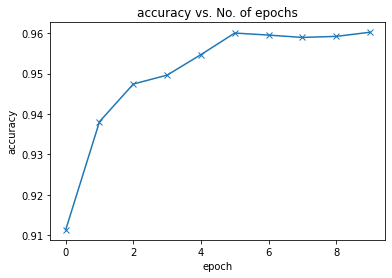

In [38]:
accs=[x['acc_at_end_of_epoch'] for x in metrics_history_third]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

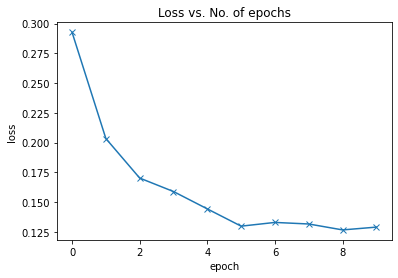

In [39]:
losses = [x['loss_at_end_of_epoch'] for x in metrics_history_third]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

baseline- dropout

In this model, we have have implemented 3 drop outs
A way to overcome overfitting is by performing dropout. Dropout is a regularization technique where some number of output layers are randomly dropped out. This is like temporarily removing it from the network.
The incoming and the outgoing edges of the dropped out node are also removed.It helps in reducing interdependence learning amongst neurons.

When we increase the dropout, the variance increases in some layers. This can lead to a lower accuracy. Increasing the dropout beyond a certain threshold will not help fit the model properly.

we have started the learning rate with 0.001 with schedular set to change learning rate every 10 epochs by 10%, but for the 3'rd dropout implemetation, we have put the step as 5 instead of 10 epochs. we could have run this implementation for more epochs, and could have gotten better results, but given our hardware, this is the best we could do. 

As we can see in the above implementation, with each increasing dropout, the accuracy is decreasing, may be because we are avoiding more and more layers, thus we might be ignoring data that might help train the network better. 